In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
# Path ke file Excel
file_path = "Data Pengangguran_Prakerja.xlsx"

# Pastikan menggunakan 'openpyxl' sebagai engine
df = pd.read_excel(file_path, engine='openpyxl', dtype=str)
print(df.head())

  No Tahun            Wilayah    TPAK Jumlah angkatan Kerja  \
0  1  2020     Kabupaten Bogor  62.65               2733670   
1  2  2020  Kabupaten Sukabumi  61.56               1146833   
2  3  2020   Kabupaten Cianjur  69.26               1185595   
3  4  2020   Kabupaten Bandung   62.2               1717376   
4  5  2020     Kabupaten Garut  61.11               1156180   

  Jumlah pengangguran terbuka   TPT  laki-laki perempuan SD ke bawah    SMP  \
0                      390731  14.29    262345    128386       67522  72817   
1                      110098    9.6     76168     33930       27546  30293   
2                      131016  11.05     95492     35324       42686  30918   
3                      147402   8.58    101373     46029       20621  39856   
4                      103607   8.95     74341     29266       27867  26971   

     SMA     SMK Diploma I/II/III/Akademi/Universitas sk penetapan  Aktif   
0  75799  119828                                39977         98893  

In [ ]:
##Missing Value Handling untuk mengecek data csv terdapat missing value atau tidak
# Cek jumlah NaN awal
print("Missing Value:")
print(df.isnull().sum())

# Ganti "-" dengan NaN (supaya tidak error saat transformasi)
df.replace("-", np.nan, inplace=True)

# Drop kolom yang lebih dari 90% datanya kosong (jika ada)
df.dropna(axis=1, thresh=0.1 * len(df), inplace=True)
df.columns = df.columns.str.strip()  # Menghapus spasi di awal/akhir nama kolom

Missing Value:
No                                      0
Tahun                                   0
Wilayah                                 0
 TPAK                                   0
Jumlah angkatan Kerja                   0
Jumlah pengangguran terbuka             0
TPT                                     0
laki-laki                               0
perempuan                               0
SD ke bawah                             1
SMP                                     0
SMA                                     0
SMK                                     0
Diploma I/II/III/Akademi/Universitas    6
sk penetapan                            0
Aktif                                   0
dtype: int64


In [ ]:
# Imputasi untuk kolom numerik menggunakan rata-rata (mean)
imputer = SimpleImputer(strategy="mean")
df[['SD ke bawah', 'Diploma I/II/III/Akademi/Universitas']] = imputer.fit_transform(df[['SD ke bawah', 'Diploma I/II/III/Akademi/Universitas']])

# Cek missing values setelah imputasi
print("✅ Data setelah imputasi missing values:")
print(df.isnull().sum())


✅ Data setelah imputasi missing values:
No                                      0
Tahun                                   0
Wilayah                                 0
TPAK                                    0
Jumlah angkatan Kerja                   0
Jumlah pengangguran terbuka             0
TPT                                     0
laki-laki                               0
perempuan                               0
SD ke bawah                             0
SMP                                     0
SMA                                     0
SMK                                     0
Diploma I/II/III/Akademi/Universitas    0
sk penetapan                            0
Aktif                                   0
dtype: int64


In [ ]:
print(df.duplicated().sum())  # Melihat jumlah data duplikat

0


In [ ]:
# Salin dataset
X = df.copy()

# Hapus spasi di awal/akhir nama kolom
X.columns = X.columns.str.strip()

# Label Encoding Wilayah
if "Wilayah" in X.columns:
    label_encoder = LabelEncoder()
    X["Wilayah_Encoded"] = label_encoder.fit_transform(X["Wilayah"])  # Simpan hasil encoding

# Konversi kolom numerik ke tipe float
numeric_columns = [
    "Jumlah angkatan Kerja", "Jumlah pengangguran terbuka", "TPT", "laki-laki", "perempuan",
    "SD ke bawah", "SMP", "SMA", "SMK", "Diploma I/II/III/Akademi/Universitas", "sk penetapan","Aktif"
]
# Fungsi membersihkan nilai numerik tanpa pembulatan
def clean_numeric(col):
    return (X[col]
            .astype(str)
            .str.replace(',', '', regex=True)  # Hapus koma pemisah ribuan
            .replace('-', np.nan)  # Ganti '-' dengan NaN jika ada
            .astype(float)  # Ubah ke float agar desimal tetap terbaca
           )

# Menerapkan pembersihan ke semua kolom numerik yang tersedia di dataset
for col in numeric_columns:
    if col in X.columns:
        try:
            X[col] = clean_numeric(col)
        except ValueError as e:
            print(f"Error pada kolom {col}: {e}")  # Deteksi error jika ada

# Konversi kolom 'Tahun', 'TPAK', dan 'TPT' menjadi numerik
X['Tahun'] = pd.to_numeric(X['Tahun'], errors='coerce')  # Ganti yang tidak bisa diubah jadi NaN
X['TPAK'] = pd.to_numeric(X['TPAK'], errors='coerce')  # Sama seperti di atas
X['TPT'] = pd.to_numeric(X['TPT'], errors='coerce')  # Sama seperti di atas

# Pastikan kolom Wilayah tetap ada
print(X.info())  # Cek tipe data setelah konversi



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   No                                    135 non-null    object 
 1   Tahun                                 135 non-null    int64  
 2   Wilayah                               135 non-null    object 
 3   TPAK                                  135 non-null    float64
 4   Jumlah angkatan Kerja                 135 non-null    float64
 5   Jumlah pengangguran terbuka           135 non-null    float64
 6   TPT                                   135 non-null    float64
 7   laki-laki                             135 non-null    float64
 8   perempuan                             135 non-null    float64
 9   SD ke bawah                           135 non-null    float64
 10  SMP                                   135 non-null    float64
 11  SMA                

In [ ]:
X_prakerja = df[[
    "TPT", "Jumlah pengangguran terbuka", "Aktif","TPAK", "Jumlah angkatan Kerja",
    "laki-laki", "perempuan",  "SD ke bawah", "SMP", "SMA", "SMK", "Diploma I/II/III/Akademi/Universitas"
]]

In [ ]:
# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Lakukan normalisasi pada X_prakerja
X_prakerja_ready = scaler.fit_transform(X_prakerja)

# Mengonversi hasil normalisasi kembali ke DataFrame untuk kemudahan analisis
X_prakerja_ready_df = pd.DataFrame(X_prakerja_ready, columns=X_prakerja.columns)

# Menampilkan DataFrame hasil normalisasi
print(X_prakerja_ready_df.head())


        TPT  Jumlah pengangguran terbuka     Aktif      TPAK  \
0  1.000000                     1.000000  0.658548  0.283081   
1  0.632733                     0.274201  0.204040  0.238427   
2  0.746280                     0.328301  0.198586  0.553871   
3  0.552858                     0.370680  0.488472  0.264646   
4  0.581832                     0.257414  0.261611  0.219992   

   Jumlah angkatan Kerja  laki-laki  perempuan  SD ke bawah       SMP  \
0               0.943482   1.000000   1.000000     0.636916  1.000000   
1               0.395497   0.285232   0.256082     0.259039  0.412530   
2               0.408883   0.359421   0.267061     0.402151  0.421165   
3               0.592524   0.381999   0.351372     0.193580  0.544643   
4               0.398725   0.278218   0.219349     0.262073  0.366637   

        SMA       SMK  Diploma I/II/III/Akademi/Universitas  
0  1.000000  1.000000                              0.399037  
1  0.380846  0.108476                              0

In [ ]:
## MEMBANGUN SIMILAR MATRIX
from sklearn.metrics.pairwise import pairwise_kernels

# Compute the affinity matrix using the Gaussian (RBF) kernel
gamma = 1.0  # The bandwidth parameter
affinity_matrix_gaussian = pairwise_kernels(X_prakerja_ready, metric='rbf', gamma=gamma)

# Display the Affinity Matrix
print("✅ Affinity Matrix (Gaussian Kernel):")
print(affinity_matrix_gaussian)


✅ Affinity Matrix (Gaussian Kernel):
[[1.         0.01798706 0.02537533 ... 0.00379135 0.00387542 0.00295922]
 [0.01798706 1.         0.85745737 ... 0.69755723 0.63239232 0.44919788]
 [0.02537533 0.85745737 1.         ... 0.64886764 0.61526629 0.39486316]
 ...
 [0.00379135 0.69755723 0.64886764 ... 1.         0.89931338 0.78435735]
 [0.00387542 0.63239232 0.61526629 ... 0.89931338 1.         0.8072577 ]
 [0.00295922 0.44919788 0.39486316 ... 0.78435735 0.8072577  1.        ]]


In [ ]:
## MEMBANGUN Degree Matrix
# Degree Matrix (D) adalah jumlah kemiripan untuk setiap titik
degree_matrix = np.sum(affinity_matrix_gaussian, axis=1)

# Membuat matriks diagonal dari derajat
degree_matrix = np.diag(degree_matrix)

# Tampilkan Degree Matrix
print("✅ Degree Matrix (D):")
print(degree_matrix)


✅ Degree Matrix (D):
[[ 4.25433796  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         86.72347767  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         79.85211855 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 83.34780958  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         77.69559833
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  53.83603643]]


In [ ]:
# Laplacian Matrix (L) = Degree Matrix (D) - Affinity Matrix (A)
laplacian_matrix = degree_matrix - affinity_matrix_gaussian

# Tampilkan Laplacian Matrix
print("✅ Laplacian Matrix (L):")
print(laplacian_matrix)

✅ Laplacian Matrix (L):
[[ 3.25433796e+00 -1.79870565e-02 -2.53753293e-02 ... -3.79135332e-03
  -3.87542295e-03 -2.95922172e-03]
 [-1.79870565e-02  8.57234777e+01 -8.57457374e-01 ... -6.97557230e-01
  -6.32392323e-01 -4.49197883e-01]
 [-2.53753293e-02 -8.57457374e-01  7.88521185e+01 ... -6.48867640e-01
  -6.15266288e-01 -3.94863160e-01]
 ...
 [-3.79135332e-03 -6.97557230e-01 -6.48867640e-01 ...  8.23478096e+01
  -8.99313379e-01 -7.84357351e-01]
 [-3.87542295e-03 -6.32392323e-01 -6.15266288e-01 ... -8.99313379e-01
   7.66955983e+01 -8.07257696e-01]
 [-2.95922172e-03 -4.49197883e-01 -3.94863160e-01 ... -7.84357351e-01
  -8.07257696e-01  5.28360364e+01]]


In [ ]:
## EIGENVALUES DAN EIGENVECTOR
eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)

In [ ]:
from scipy.linalg import eigh

# 1. Hitung eigenvalues dan eigenvectors dari Laplacian
eigenvalues, eigenvectors = eigh(laplacian_matrix)

# 2. Ambil 2 eigenvector terkecil setelah nol (biasanya indeks 1 dan 2)
embedding_2d = eigenvectors[:, 1:3]

# 3. Cetak hasil
print("✅ 2D Spectral Embedding (dari Laplacian manual):")
print(np.round(embedding_2d, 4))


✅ 2D Spectral Embedding (dari Laplacian manual):
[[ 9.125e-01  3.883e-01]
 [-1.090e-02  6.600e-03]
 [-1.060e-02  6.200e-03]
 [-9.200e-03  4.400e-03]
 [-1.090e-02  6.600e-03]
 [-1.150e-02  7.300e-03]
 [-1.170e-02  7.600e-03]
 [-1.160e-02  7.400e-03]
 [-1.070e-02  6.500e-03]
 [-1.170e-02  7.600e-03]
 [-1.150e-02  7.400e-03]
 [-1.130e-02  7.200e-03]
 [-1.140e-02  7.200e-03]
 [-1.160e-02  7.500e-03]
 [-1.050e-02  6.300e-03]
 [-4.300e-03  2.000e-03]
 [-1.120e-02  7.000e-03]
 [-1.200e-02  7.900e-03]
 [-1.140e-02  7.200e-03]
 [-1.190e-02  7.800e-03]
 [-9.500e-03  5.300e-03]
 [-1.180e-02  7.800e-03]
 [-9.500e-03  5.500e-03]
 [-1.080e-02  6.600e-03]
 [-1.170e-02  7.600e-03]
 [-1.170e-02  7.600e-03]
 [-1.190e-02  7.800e-03]
 [ 3.224e-01 -5.988e-01]
 [-1.080e-02  6.400e-03]
 [-1.100e-02  6.600e-03]
 [-1.010e-02  5.400e-03]
 [-1.100e-02  6.600e-03]
 [-1.160e-02  7.400e-03]
 [-1.170e-02  7.600e-03]
 [-1.150e-02  7.400e-03]
 [-1.110e-02  6.800e-03]
 [-1.170e-02  7.500e-03]
 [-1.150e-02  7.400e-03]
 

Shape eigenvectors: (135, 135)
Embedding 2D shape: (135, 2)
Embedding 2D:
[[-5.27702221e-01  2.45328351e-01]
 [-1.82677472e-02 -6.61085490e-02]
 [-2.74478806e-02 -7.90865667e-02]
 [-6.58256417e-02 -1.18912248e-01]
 [-1.64250848e-02 -6.14401957e-02]
 [ 1.71186126e-02  2.10864533e-02]
 [ 3.49486849e-02  8.13661476e-02]
 [ 2.29216159e-02  4.28883576e-02]
 [-2.41689594e-02 -6.96664451e-02]
 [ 3.45467058e-02  7.94890382e-02]
 [ 2.05369695e-02  3.37750208e-02]
 [ 7.62560482e-03 -4.86136857e-03]
 [ 1.05809271e-02  2.12189458e-03]
 [ 2.91997119e-02  6.47703759e-02]
 [-3.38556060e-02 -8.88158311e-02]
 [-1.22636263e-01 -1.33867820e-01]
 [-1.42922025e-03 -2.27974415e-02]
 [ 4.39962141e-02  1.19980434e-01]
 [ 6.05385496e-03 -2.78756313e-03]
 [ 3.57787870e-02  9.34411357e-02]
 [-6.00492530e-02 -1.23347354e-01]
 [ 4.19098625e-02  1.11156919e-01]
 [-6.15341829e-02 -1.31707463e-01]
 [-2.24091063e-02 -7.19662391e-02]
 [ 2.84291182e-02  6.42881169e-02]
 [ 3.99806911e-02  1.00309843e-01]
 [ 4.81628009e-0

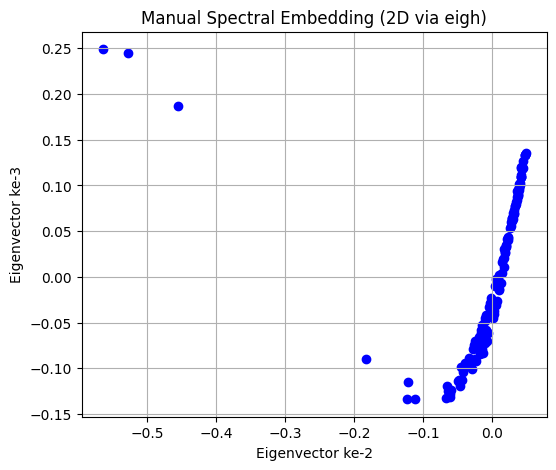

In [ ]:
from scipy.linalg import eigh
from scipy.sparse import csgraph
from sklearn.metrics.pairwise import pairwise_kernels

# Compute the affinity matrix using the Gaussian (RBF) kernel
gamma = 1.0  # The bandwidth parameter
affinity_matrix_gaussian = pairwise_kernels(X_prakerja_ready, metric='rbf', gamma=gamma)

# 1. Hitung Laplacian: L = D - A
laplacian = csgraph.laplacian(affinity_matrix_gaussian, normed=True)

# 2. Hitung eigenvalues & eigenvectors
eigenvalues, eigenvectors = eigh(laplacian)

# 3. Ambil eigenvector ke-1 dan ke-2 (setelah 0)
embedding_2d = eigenvectors[:, 1:3]  # Skip yang index 0

# 4. Print dimensi dan hasilnya
print("Shape eigenvectors:", eigenvectors.shape)
print("Embedding 2D shape:", embedding_2d.shape)
print("Embedding 2D:")
print(embedding_2d)

# 5. Visualisasi
plt.figure(figsize=(6, 5))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c='blue')
plt.title("Manual Spectral Embedding (2D via eigh)")
plt.xlabel("Eigenvector ke-2")
plt.ylabel("Eigenvector ke-3")
plt.grid(True)
plt.show()


In [ ]:
# 1. Ambil k eigenvector teratas (misalnya 2 untuk dimensi 2D)
k = 2  # Pilih jumlah dimensi yang diinginkan untuk Spectral Clustering
eigenvector_subset = eigenvectors[:, :k]

# 2. Terapkan Spectral Clustering menggunakan eigenvectors yang telah dihitung
spectral_clustering = SpectralClustering( n_clusters=2, affinity='nearest_neighbors', random_state=42)

# 3. Melakukan klasterisasi
cluster_labels = spectral_clustering.fit_predict(eigenvector_subset)

# 4. Menambahkan hasil klasterisasi ke DataFrame
df['Cluster'] = cluster_labels

# 5. Menampilkan hasil klasterisasi beserta data lainnya
print("✅ Hasil Klasterisasi dengan Spectral Clustering:")
print(df[['Tahun', 'Wilayah', 'Cluster']])

df.to_csv('Analisis Pertahun.csv', index=False)

✅ Hasil Klasterisasi dengan Spectral Clustering:
    Tahun             Wilayah  Cluster
0    2020     Kabupaten Bogor        0
1    2020  Kabupaten Sukabumi        0
2    2020   Kabupaten Cianjur        0
3    2020   Kabupaten Bandung        0
4    2020     Kabupaten Garut        0
..    ...                 ...      ...
130  2024         Kota Bekasi        0
131  2024          Kota Depok        0
132  2024         Kota Cimahi        1
133  2024    Kota Tasikmalaya        1
134  2024         Kota Banjar        1

[135 rows x 3 columns]


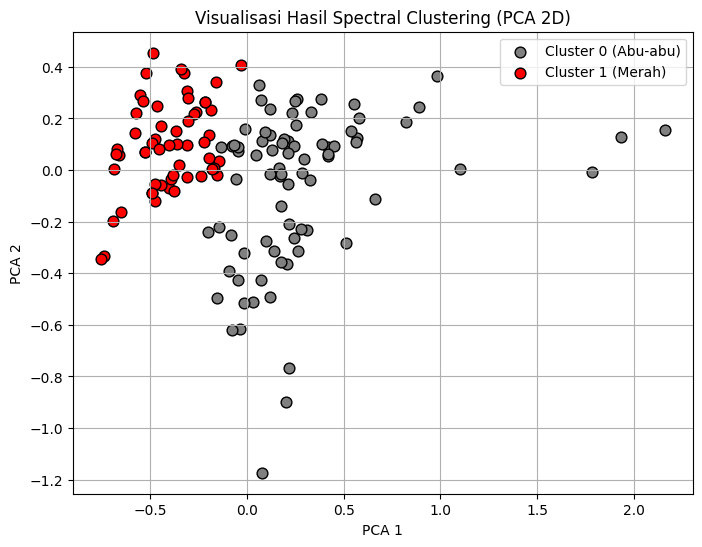

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

# Jalankan Spectral Clustering
spectral = SpectralClustering(
    n_clusters=2,
    affinity='nearest_neighbors',
    n_neighbors=10,
    random_state=42
)
labels = spectral.fit_predict(X_prakerja_ready)

# Reduksi dimensi ke 2D untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_prakerja_ready)

plt.figure(figsize=(8,6))

# Plot masing-masing cluster dengan warna & label
plt.scatter(
    X_pca[labels == 0, 0],
    X_pca[labels == 0, 1],
    color='gray',
    label='Cluster 0 (Abu-abu)',
    s=60,
    edgecolor='k'
)
plt.scatter(
    X_pca[labels == 1, 0],
    X_pca[labels == 1, 1],
    color='red',
    label='Cluster 1 (Merah)',
    s=60,
    edgecolor='k'
)

plt.title("Visualisasi Hasil Spectral Clustering (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Menghitung Silhouette Score untuk mengevaluasi hasil klasterisasi
sil_score = silhouette_score(X_prakerja_ready, cluster_labels)

# Menampilkan Silhouette Score
print(f"✅ Silhouette Score: {sil_score:.4f}")

✅ Silhouette Score: 0.2808


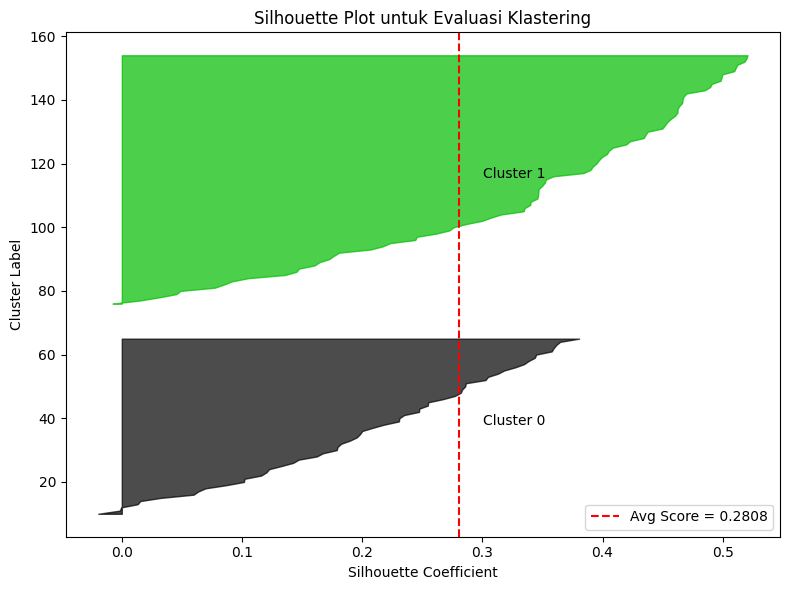

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples

# Misalnya: kamu sudah punya
# X_prakerja_ready = data hasil embedding / representasi 2D
# cluster_labels = hasil label klaster (misal dari KMeans atau Spectral Clustering)

# 1. Hitung Silhouette Score dan per sample
silhouette_avg = silhouette_score(X_prakerja_ready, cluster_labels)
sample_silhouette_values = silhouette_samples(X_prakerja_ready, cluster_labels)

# 2. Visualisasi Silhouette Plot
n_clusters = len(np.unique(cluster_labels))
fig, ax1 = plt.subplots(figsize=(8, 6))

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Kode yang sudah diperbaiki
# Kode Perbaikan
    ax1.text(silhouette_avg + 0.02, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    y_lower = y_upper + 10  # jarak antar cluster

# 3. Garis rata-rata Silhouette Score
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Avg Score = {silhouette_avg:.4f}")
ax1.set_title("Silhouette Plot untuk Evaluasi Klastering")
ax1.set_xlabel("Silhouette Coefficient")
ax1.set_ylabel("Cluster Label")
ax1.legend(loc='lower right')
plt.tight_layout()
plt.show()


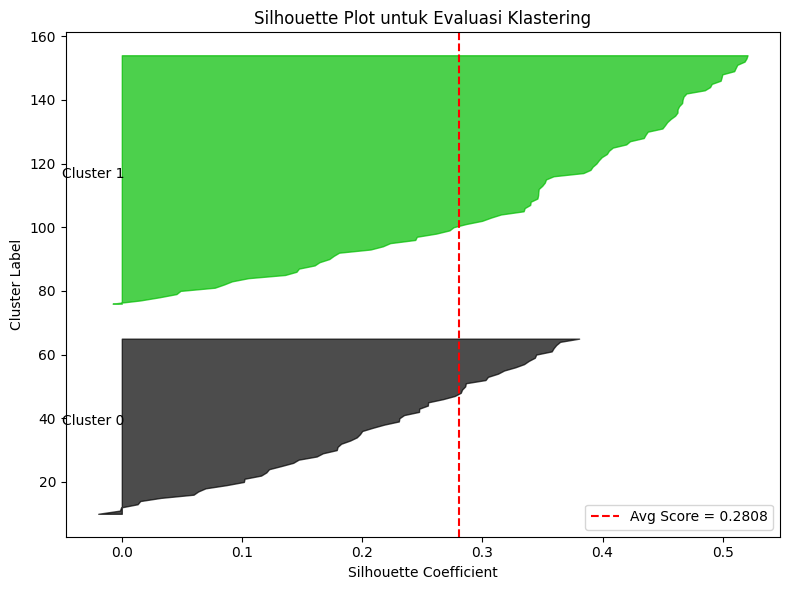

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples

# Misalnya: kamu sudah punya
# X_prakerja_ready = data hasil embedding / representasi 2D
# cluster_labels = hasil label klaster (misal dari KMeans atau Spectral Clustering)

# 1. Hitung Silhouette Score dan per sample
silhouette_avg = silhouette_score(X_prakerja_ready, cluster_labels)
sample_silhouette_values = silhouette_samples(X_prakerja_ready, cluster_labels)

# 2. Visualisasi Silhouette Plot
n_clusters = len(np.unique(cluster_labels))
fig, ax1 = plt.subplots(figsize=(8, 6))

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    y_lower = y_upper + 10  # jarak antar cluster

# 3. Garis rata-rata Silhouette Score
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Avg Score = {silhouette_avg:.4f}")
ax1.set_title("Silhouette Plot untuk Evaluasi Klastering")
ax1.set_xlabel("Silhouette Coefficient")
ax1.set_ylabel("Cluster Label")
ax1.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Misalnya df sudah berisi kolom 'Cluster' yang sudah dihasilkan sebelumnya
# Kelompokkan data berdasarkan 'Wilayah' dan ambil modus untuk kolom 'Cluster'
df['Cluster'] = df.groupby('Wilayah')['Cluster'].transform(lambda x: x.mode()[0])

# Sekarang setiap wilayah hanya memiliki satu klaster berdasarkan modus
# Tampilkan hasilnya
print(df[['Wilayah', 'Cluster']].drop_duplicates())

                    Wilayah  Cluster
0           Kabupaten Bogor        0
1        Kabupaten Sukabumi        0
2         Kabupaten Cianjur        0
3         Kabupaten Bandung        0
4           Kabupaten Garut        0
5     Kabupaten Tasikmalaya        1
6          Kabupaten Ciamis        1
7        Kabupaten Kuningan        1
8         Kabupaten Cirebon        0
9      Kabupaten Majalengka        1
10       Kabupaten Sumedang        1
11      Kabupaten Indramayu        1
12         Kabupaten Subang        1
13     Kabupaten Purwakarta        1
14       Kabupaten Karawang        0
15         Kabupaten Bekasi        0
16  Kabupaten Bandung Barat        1
17    Kabupaten Pangandaran        1
18               Kota Bogor        1
19            Kota Sukabumi        1
20             Kota Bandung        0
21             Kota Cirebon        1
22              Kota Bekasi        0
23               Kota Depok        0
24              Kota Cimahi        1
25         Kota Tasikmalaya        1
2

In [ ]:
# Ubah kolom numerik ke tipe float
kolom_numerik = [
    'TPT', 'Jumlah pengangguran terbuka', 'Aktif', 'TPAK', 'Jumlah angkatan Kerja',
    'laki-laki', 'perempuan', 'SD ke bawah', 'SMP', 'SMA', 'SMK',
    'Diploma I/II/III/Akademi/Universitas'
]

for kolom in kolom_numerik:
    df[kolom] = pd.to_numeric(df[kolom], errors='coerce')

# Menggabungkan data dan menghitung rata-rata semua kolom numerik
average_cluster_data = df.groupby(['Cluster', 'Wilayah', 'Tahun']).agg({
    'TPT': 'mean',
    'Jumlah pengangguran terbuka': 'mean',
    'Aktif': 'mean',
    'TPAK': 'mean',
    'Jumlah angkatan Kerja': 'mean',
    'laki-laki': 'mean',
    'perempuan': 'mean',
    'SD ke bawah': 'mean',
    'SMP': 'mean',
    'SMA': 'mean',
    'SMK': 'mean',
    'Diploma I/II/III/Akademi/Universitas': 'mean'
}).reset_index()

# Menampilkan hasil
print(average_cluster_data.head())

# Menyimpan ke CSV (rata-rata)
average_cluster_data.to_csv('Rata-rata prakerja & Pengangguran pertahun.csv', index=False)


   Cluster            Wilayah Tahun   TPT  Jumlah pengangguran terbuka  \
0        0  Kabupaten Bandung  2020  8.58                     147402.0   
1        0  Kabupaten Bandung  2021  8.32                     151908.0   
2        0  Kabupaten Bandung  2022  6.98                     126289.0   
3        0  Kabupaten Bandung  2023  6.52                     122429.0   
4        0  Kabupaten Bandung  2024  6.36                     121455.0   

     Aktif   TPAK  Jumlah angkatan Kerja  laki-laki  perempuan  SD ke bawah  \
0  65955.0  62.20              1717376.0   101373.0    46029.0      20621.0   
1  61428.0  65.12              1824927.0   106884.0    45024.0      29774.0   
2  63304.0  63.64              1808799.0    83269.0    43020.0      15497.0   
3  19389.0  67.10              1878757.0    84723.0    37706.0      24585.0   
4  32848.0  67.22              1910662.0    83094.0    38361.0      24630.0   

       SMP      SMA      SMK  Diploma I/II/III/Akademi/Universitas  
0  39856.0 

In [ ]:
# Ubah kolom numerik ke float
kolom_numerik = [
    'TPT', 'Jumlah pengangguran terbuka', 'Aktif', 'TPAK', 'Jumlah angkatan Kerja',
    'laki-laki', 'perempuan', 'SD ke bawah', 'SMP', 'SMA', 'SMK',
    'Diploma I/II/III/Akademi/Universitas'
]

for kolom in kolom_numerik:
    df[kolom] = pd.to_numeric(df[kolom], errors='coerce')

# Hitung rata-rata berdasarkan Cluster (0, 1, dst)
rata_rata_klaster = df.groupby('Cluster')[kolom_numerik].mean().reset_index()

# Tampilkan hasil
print(rata_rata_klaster)


   Cluster       TPT  Jumlah pengangguran terbuka         Aktif       TPAK  \
0        0  8.954182                137208.981818  37580.709091  65.767455   
1        1  7.645250                 41635.600000  12235.700000  66.634125   

   Jumlah angkatan Kerja     laki-laki     perempuan   SD ke bawah  \
0           1.513606e+06  90828.327273  45192.690909  29165.309091   
1           5.580275e+05  26538.087500  13441.587500  16158.406437   

            SMP           SMA           SMK  \
0  26385.690909  33945.509091  35560.345455   
1  13879.687500  12981.175000  13954.562500   

   Diploma I/II/III/Akademi/Universitas  
0                          18866.129669  
1                          12589.365795  


In [ ]:
# Membaca data
data_prakerja = pd.read_csv('Analisis Pertahun.csv')

# Menghitung korelasi antara 'Aktif' dan 'TPT'
kor_relasi = data_prakerja[['Aktif', 'TPT']].corr()

# Menampilkan hasil korelasi
print(kor_relasi)

          Aktif       TPT
Aktif  1.000000  0.348502
TPT    0.348502  1.000000


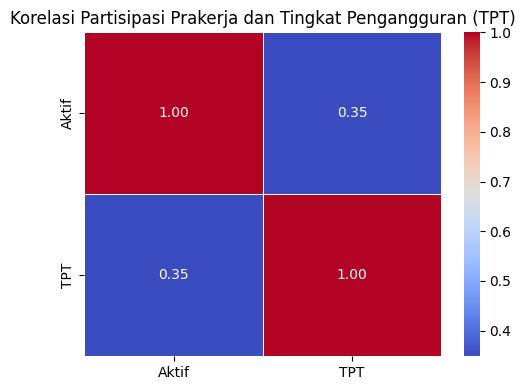

In [ ]:
# Visualisasi heatmap korelasi
plt.figure(figsize=(5, 4))
sns.heatmap(kor_relasi, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Korelasi Partisipasi Prakerja dan Tingkat Pengangguran (TPT)')
plt.tight_layout()
plt.show()

In [ ]:
# Menghapus spasi ekstra di nama kolom
data_prakerja.columns = data_prakerja.columns.str.strip()

# Menghitung korelasi antara 'Aktif' dan 'TPT'
kor_relasi = data_prakerja[['Aktif', 'SD ke bawah', 'SMP', 'SMA', 'SMK', 'Diploma I/II/III/Akademi/Universitas']].corr()

# Menampilkan hasil korelasi
print(kor_relasi)


                                         Aktif  SD ke bawah       SMP  \
Aktif                                 1.000000     0.405203  0.392958   
SD ke bawah                           0.405203     1.000000  0.841563   
SMP                                   0.392958     0.841563  1.000000   
SMA                                   0.635915     0.529956  0.625747   
SMK                                   0.631092     0.421256  0.521790   
Diploma I/II/III/Akademi/Universitas  0.052331     0.318594  0.468240   

                                           SMA       SMK  \
Aktif                                 0.635915  0.631092   
SD ke bawah                           0.529956  0.421256   
SMP                                   0.625747  0.521790   
SMA                                   1.000000  0.821056   
SMK                                   0.821056  1.000000   
Diploma I/II/III/Akademi/Universitas  0.372246  0.305930   

                                      Diploma I/II/III/Akademi/Univ

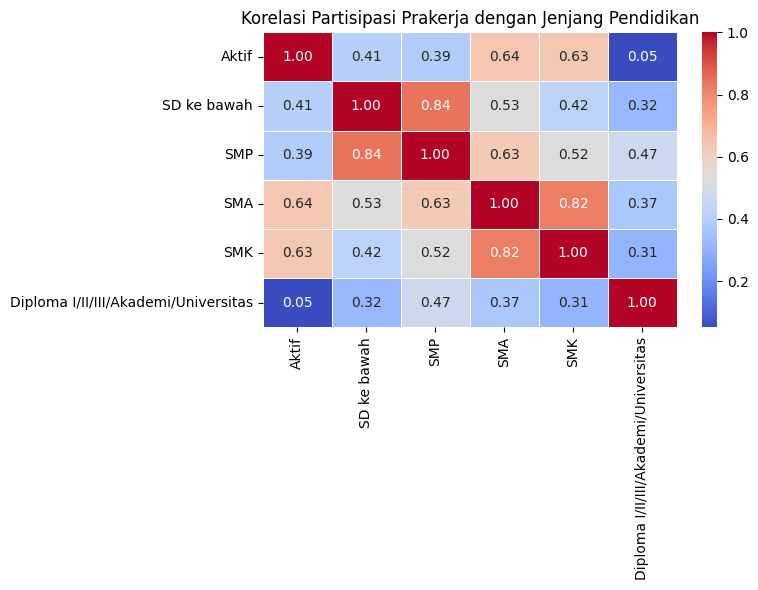

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(kor_relasi, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Korelasi Partisipasi Prakerja dengan Jenjang Pendidikan')
plt.tight_layout()
plt.show()


In [ ]:
# 1. Hitung rata-rata partisipasi aktif per wilayah
avg_aktif_per_wilayah = data_prakerja.groupby('Wilayah')['Aktif'].mean().reset_index()

# 2. Hitung median partisipasi
median_aktif = avg_aktif_per_wilayah['Aktif'].median()

# 3. Bagi wilayah berdasarkan partisipasi tinggi vs rendah
wilayah_tinggi = avg_aktif_per_wilayah[avg_aktif_per_wilayah['Aktif'] > median_aktif]['Wilayah']
wilayah_rendah = avg_aktif_per_wilayah[avg_aktif_per_wilayah['Aktif'] <= median_aktif]['Wilayah']

# 4. Filter data asli berdasarkan kelompok wilayah
data_tinggi = data_prakerja[data_prakerja['Wilayah'].isin(wilayah_tinggi)]
data_rendah = data_prakerja[data_prakerja['Wilayah'].isin(wilayah_rendah)]

# 5. Hitung rata-rata TPT tahun 2020 dan setelahnya
avg_tpt_tinggi_2020 = data_tinggi[data_tinggi['Tahun'] == 2020]['TPT'].mean()
avg_tpt_tinggi_after = data_tinggi[data_tinggi['Tahun'] >= 2021]['TPT'].mean()

avg_tpt_rendah_2020 = data_rendah[data_rendah['Tahun'] == 2020]['TPT'].mean()
avg_tpt_rendah_after = data_rendah[data_rendah['Tahun'] >= 2021]['TPT'].mean()

# 6. Cetak hasil
print(f"Rata-rata TPT partisipasi tinggi 2020: {avg_tpt_tinggi_2020:.2f}")
print(f"Rata-rata TPT partisipasi tinggi setelahnya: {avg_tpt_tinggi_after:.2f}\n")

print(f"Rata-rata TPT partisipasi rendah 2020: {avg_tpt_rendah_2020:.2f}")
print(f"Rata-rata TPT partisipasi rendah setelahnya: {avg_tpt_rendah_after:.2f}\n")

print("Wilayah dengan partisipasi tinggi:")
print(wilayah_tinggi.values)

print("\nWilayah dengan partisipasi rendah:")
print(wilayah_rendah.values)


Rata-rata TPT partisipasi tinggi 2020: 10.63
Rata-rata TPT partisipasi tinggi setelahnya: 8.23

Rata-rata TPT partisipasi rendah 2020: 9.38
Rata-rata TPT partisipasi rendah setelahnya: 7.27

Wilayah dengan partisipasi tinggi:
['Kabupaten Bandung' 'Kabupaten Bandung Barat' 'Kabupaten Bekasi'
 'Kabupaten Bogor' 'Kabupaten Cianjur' 'Kabupaten Cirebon'
 'Kabupaten Garut' 'Kabupaten Karawang' 'Kabupaten Sukabumi'
 'Kabupaten Tasikmalaya' 'Kota Bandung' 'Kota Bekasi' 'Kota Depok']

Wilayah dengan partisipasi rendah:
['Kabupaten Ciamis' 'Kabupaten Indramayu' 'Kabupaten Kuningan'
 'Kabupaten Majalengka' 'Kabupaten Pangandaran' 'Kabupaten Purwakarta'
 'Kabupaten Subang' 'Kabupaten Sumedang' 'Kota Banjar' 'Kota Bogor'
 'Kota Cimahi' 'Kota Cirebon' 'Kota Sukabumi' 'Kota Tasikmalaya']
